# DeepSet Flow Matching Posterior Estimation with Burst Data

This notebook demonstrates how to perform flow matching posterior estimation (FMPE) using a DeepSet architecture with LAMPE, specifically tailored to handle burst data simulations.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from itertools import islice
from lampe.data import JointLoader
from lampe.plots import corner, mark_point, nice_rc
from lampe.utils import GDStep
from tqdm import trange

from fmpe_deep_sets import DeepSetFMPE, DeepSetFMPELoss
from generate_burst_data import simulate_burst

## Simulator Setup

The simulator is permutation invariant to the order of the input parameters. We define a time array and parameters for the burst model. The `simulate_burst` function is used to generate burst data.

In [2]:
# Example usage
time = np.linspace(0, 1.0, 1000)  # Time array
ncomp = 3  # Number of components

# Parameters for the burst model
t0_lower = time[0] + 0.1
t0_upper = time[-1] - 0.1
amp_lower = 2
amp_upper = 5
rise_val = 0.02
skew_val = 4

def generate_burst_params():
    t0 = np.random.uniform(t0_lower, t0_upper, size=ncomp)
    amp = np.random.uniform(amp_lower, amp_upper, size=ncomp)
    rise = np.ones(ncomp) * rise_val
    skew = np.ones(ncomp) * skew_val
    return np.hstack([t0, amp*10, rise, skew])

ybkg = 1.0  # Background flux

## Training

We train a DeepSetFMPE model to learn the vector field that induces a normalizing flow between the posterior distribution $p(\theta | x)$ and a standard Gaussian distribution $\mathcal{N}(0, I)$. The training involves minimizing the FMPE loss.

In [3]:
estimator = DeepSetFMPE(theta_dim=4*ncomp, x_dim=1000, freqs=5)
loss = DeepSetFMPELoss(estimator)
optimizer = optim.Adam(estimator.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 128)
step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping

estimator.train()

for epoch in (bar := trange(128, unit='epoch')):
    losses = []

    for _ in range(256):  # 256 batches per epoch
        burstparams = generate_burst_params()
        ymodel, ycounts = simulate_burst(time, ncomp, burstparams, ybkg * 10, return_model=True)
        theta = torch.from_numpy(burstparams).float()
        x = torch.from_numpy(ycounts).float()
        losses.append(step(loss(theta, x)))

    bar.set_postfix(loss=torch.stack(losses).mean().item())

100%|██████████| 128/128 [00:32<00:00,  3.96epoch/s, loss=14.5]


## Inference

After training, we use the DeepSetFMPE model to perform inference. We sample from the normalizing flow $p_\phi(\theta | x)$ it induces.

In [4]:
burstparams_star = generate_burst_params()
ymodel_star, ycounts_star = simulate_burst(time, ncomp, burstparams_star, ybkg * 10, return_model=True)
theta_star = torch.from_numpy(burstparams_star).float()
x_star = torch.from_numpy(ycounts_star).float()

estimator.eval()

with torch.no_grad():
    log_p = estimator.flow(x_star).log_prob(theta_star)
    samples = estimator.flow(x_star).sample((2**14,))

## Visualization

We visualize the posterior samples and the true parameters to assess the quality of the inference.

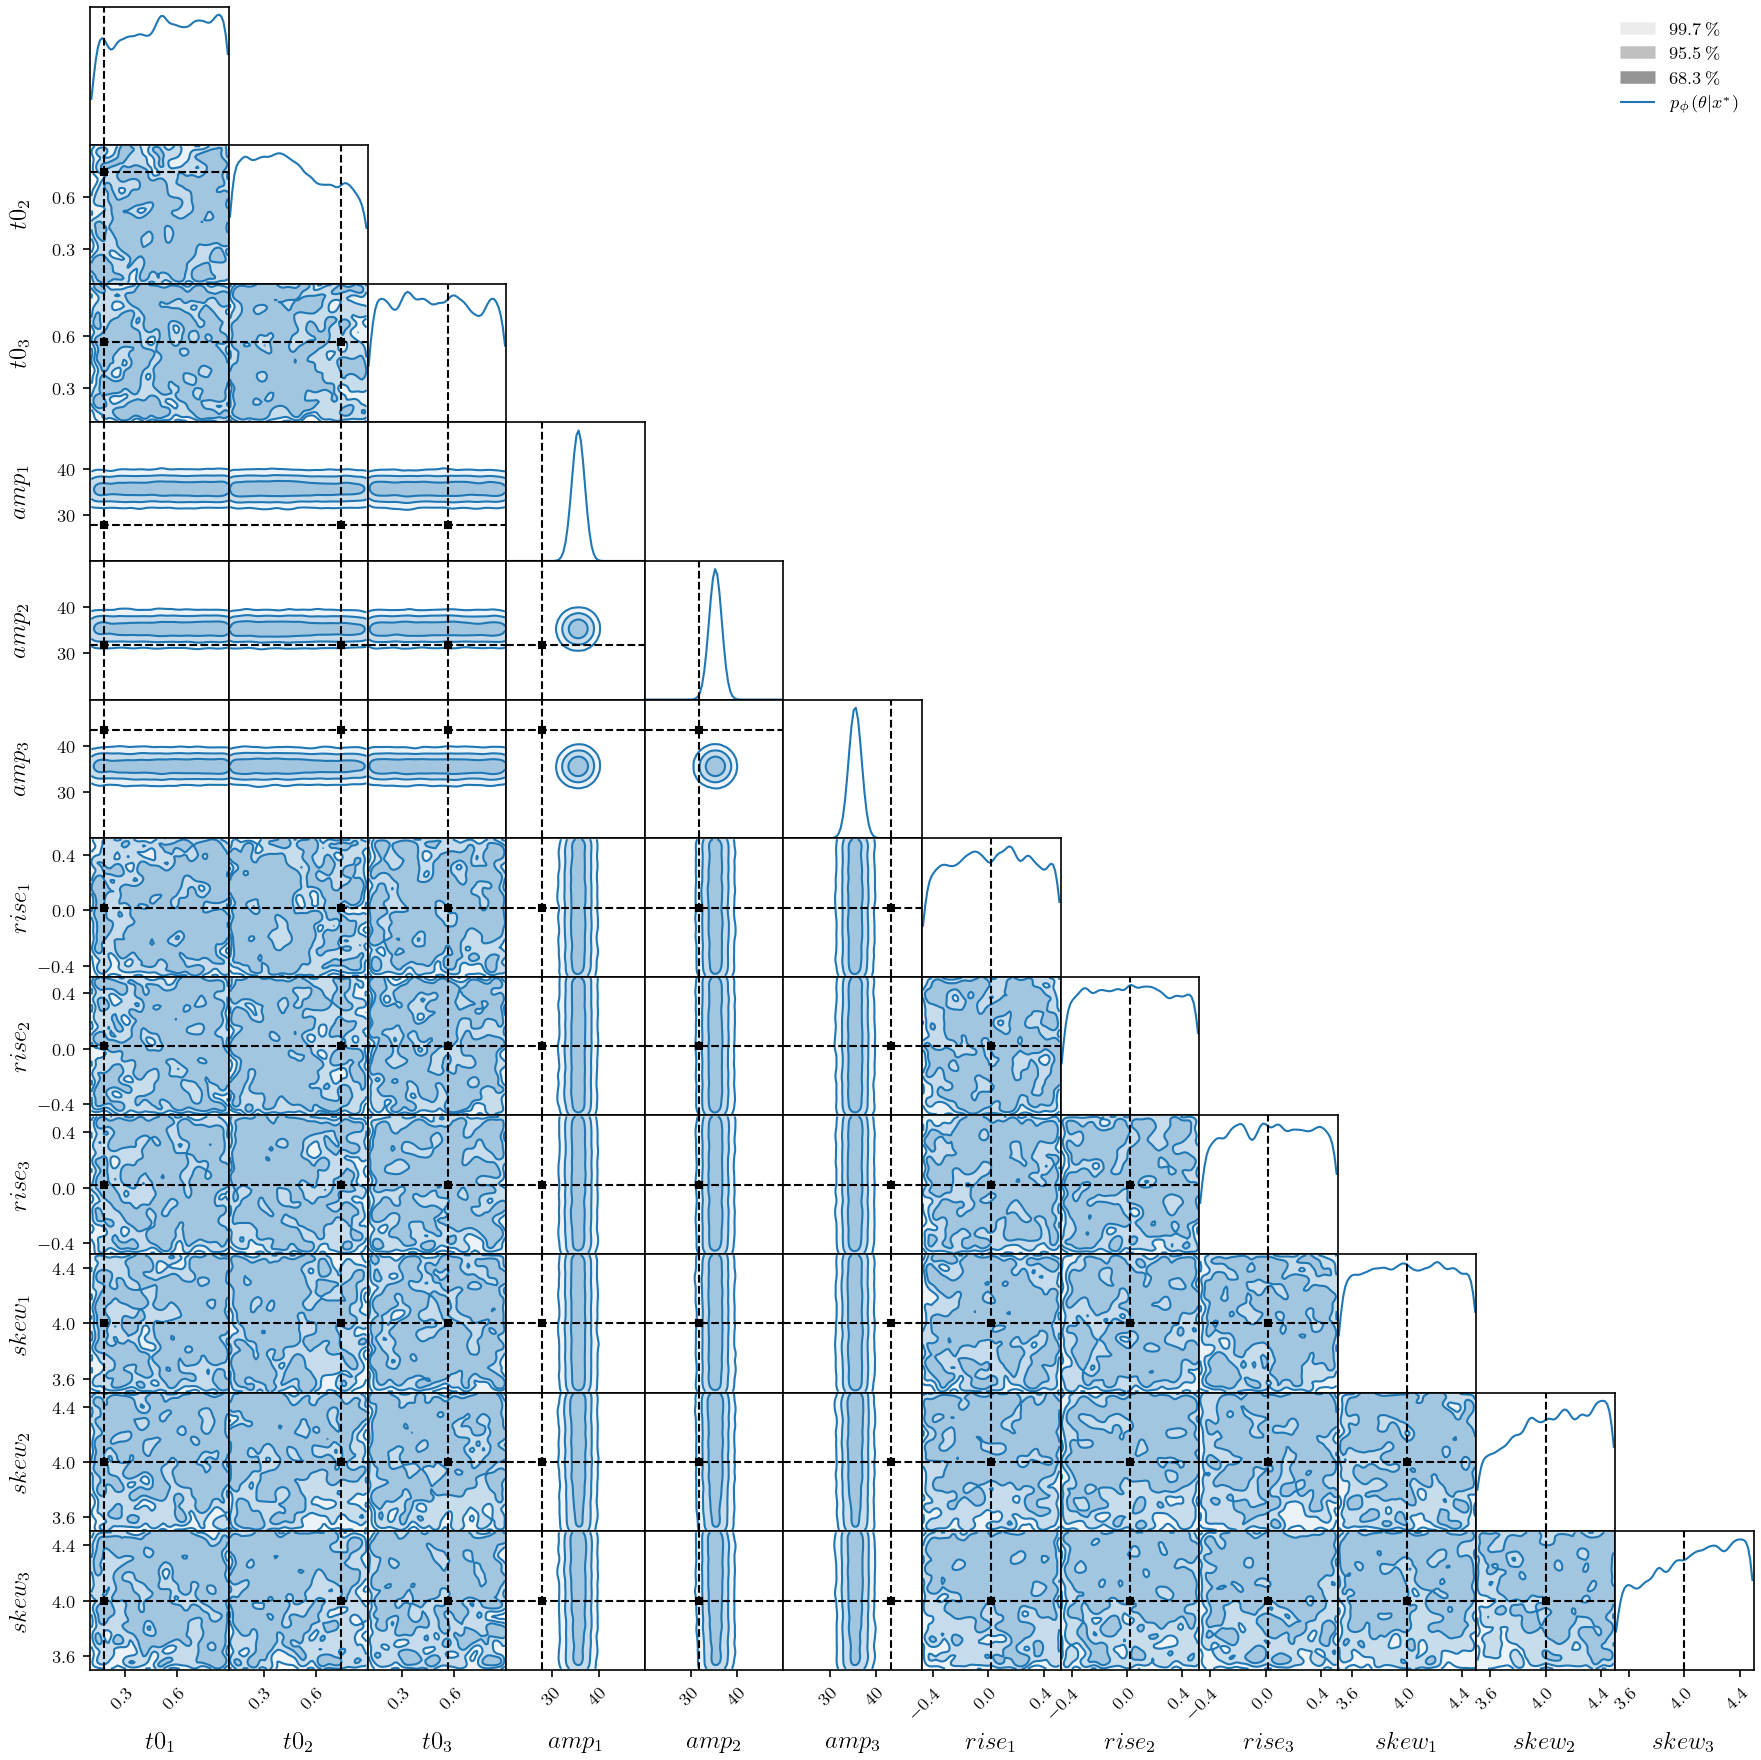

In [5]:
plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

LABELS = [f'$t0_{i+1}$' for i in range(ncomp)] + \
         [f'$amp_{i+1}$' for i in range(ncomp)] + \
         [f'$rise_{i+1}$' for i in range(ncomp)] + \
         [f'$skew_{i+1}$' for i in range(ncomp)]

LOWER = torch.tensor([t0_lower]*ncomp + [amp_lower*10]*ncomp + [rise_val]*ncomp + [skew_val]*ncomp)
UPPER = torch.tensor([t0_upper]*ncomp + [amp_upper*10]*ncomp + [rise_val]*ncomp + [skew_val]*ncomp)

fig = corner(
    samples,
    smooth=2,
    domain=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_\phi(\theta | x^*)$',
    figsize=(12, 12),
)
mark_point(fig, theta_star)

## Interpretation of the Parameter Space Visualization

The visualization generated using the `corner` function provides a comprehensive view of the posterior distributions and correlations of the parameters involved in the model. Here's a detailed interpretation of the plot:

### Axes and Labels
Each subplot in the grid represents a pair of parameters, with histograms on the diagonal showing the marginal distributions of individual parameters. The labels on the axes, such as $t0_i$, $amp_i$, $rise_i$, and $skew_i$, correspond to the parameters of the model:
- **$t0_i$**: Represents the onset time of the $i^{th}$ component.
- **$amp_i$**: Indicates the amplitude of the $i^{th}$ component, scaled by a factor of 10 for visualization purposes.
- **$rise_i$**: Denotes the rise time of the $i^{th}$ component.
- **$skew_i$**: Reflects the skewness of the $i^{th}$ component.

### Domain Constraints
The `domain` parameter in the `corner` function call specifies the lower and upper bounds for each parameter, ensuring that the plots are focused on the relevant ranges of interest. This helps in better understanding how the parameters are distributed within their feasible limits.

### Visual Enhancements
The `smooth` parameter set to 2 helps in smoothing the histograms and scatter plots, making the trends and distributions clearer and easier to interpret.

### Legend
The legend $p_\phi(\theta | x^*)$ indicates that the plots are showing the probability distributions of the parameters $\theta$, conditioned on the observed data $x^*$, as modeled by the neural network (or any other model) represented by $\phi$.

### Marked Points
The function `mark_point` is used to highlight specific points in the parameter space, typically representing the true values or estimates of the parameters $\theta^*$. This is crucial for visual comparison and to assess the accuracy of the model in estimating the parameters.

### Overall Utility
This visualization is an essential tool for understanding the behavior of the model, the interdependencies between parameters, and the confidence in the parameter estimates. It aids in diagnosing potential issues with the model, such as biases or correlations between parameters that were not accounted for in the model design.

By examining this plot, researchers and developers can gain insights into the parameter dynamics and refine their models for better accuracy and performance.